# Neanderthal

## Intro

In [14]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17893558344972185676
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4937758677198781114
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14942083482
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8463211992439103638
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7321614016520833328
physical_device_desc: "device: XLA_GPU device"
]


In [9]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, SpatialDropout1D
from keras import regularizers

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

from collections import Counter
import matplotlib.pyplot as  plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_splitt

## DNA simulation with Markov chain

In [2]:
nitro_base=["A","C","G","T"]
markov_chain={}
pdf_neanderthal={"A":[],"C":[], "G":[], "T":[]}
pdf_human={"A":[],"C":[], "G":[], "T":[]}

a = 0.50 # the larger is a and more variability in the markov probs of jump
j_mtx_h=[]
j_mtx_n=[]

print("Neanderthal")
for k in pdf_neanderthal.keys():
    probs=np.random.random(4)*2*a +(0.5-a)
    probs_nb=probs/sum(probs)
    j_mtx_n.append(probs_nb)
    print(np.cumsum(probs_nb))
    pdf_neanderthal[k]=[np.cumsum(probs_nb),nitro_base]
    
print("Human") 
for k in pdf_human.keys():
    probs=np.random.random(4)*2*a +(0.5-a)
    probs_nb=probs/sum(probs)
    j_mtx_h.append(probs_nb)
    print(np.cumsum(probs_nb))
    pdf_human[k]=[np.cumsum(probs_nb),nitro_base]

display(pd.DataFrame(pdf_human))
display(pd.DataFrame(pdf_neanderthal))

similarity = 0
for i in range(4):
    for j in range(4):
        similarity += j_mtx_h[i][j]*np.log(j_mtx_h[i][j]/j_mtx_n[i][j]) + j_mtx_n[i][j]*np.log(j_mtx_n[i][j]/j_mtx_h[i][j])
print("Kullback-Leibler symmetric divergence : ", similarity)

Neanderthal
[0.04136712 0.11555263 0.7136529  1.        ]
[0.05786986 0.45660257 0.87130854 1.        ]
[0.12683783 0.34588325 0.71076181 1.        ]
[0.39055079 0.52345277 0.79649856 1.        ]
Human
[0.24373137 0.2842872  0.54371019 1.        ]
[0.27114067 0.45726817 0.74652974 1.        ]
[0.30918451 0.434948   0.69806832 1.        ]
[0.05202506 0.14868461 0.45167903 1.        ]


,A,C,G,T
0,"[0.24373136638318216, 0.2842871981121239, 0.54...","[0.27114067339238296, 0.4572681671424977, 0.74...","[0.30918450501966865, 0.4349479993200758, 0.69...","[0.05202505739462716, 0.14868461344297007, 0.4..."
1,"[A, C, G, T]","[A, C, G, T]","[A, C, G, T]","[A, C, G, T]"


,A,C,G,T
0,"[0.04136711856989648, 0.11555262694737811, 0.7...","[0.05786985928860636, 0.456602570498028, 0.871...","[0.12683783110082844, 0.3458832453130206, 0.71...","[0.3905507938023928, 0.5234527720123691, 0.796..."
1,"[A, C, G, T]","[A, C, G, T]","[A, C, G, T]","[A, C, G, T]"


Kullback-Leibler symmetric divergence :  2.6493234261392806


In [3]:
#Build DNA

#Human
DNA_length = 18000000
human_DNA =['A']   
neanderthal_DNA = ['A']

for i in range(DNA_length-1): 
    MC=np.random.random(1)
    for lim,what in zip(pdf_human[human_DNA[-1]][0],pdf_human[human_DNA[-1]][1]):
        if(MC<=lim): 
            human_DNA.append(what)
            MC = 0
            break
print("DONE HUMAN")

#Neanderthal
for i in range(DNA_length-1):   
    MC=np.random.random(1)
    for lim,what in zip(pdf_neanderthal[human_DNA[-1]][0],pdf_neanderthal[human_DNA[-1]][1] ):
        if(MC<=lim): 
            neanderthal_DNA.append(what)
            MC = 0
            break
print("DONE NEANDERTHAL")

human_DNA=np.array(human_DNA)
neanderthal_DNA=np.array(neanderthal_DNA)
print(len(human_DNA))
print(len(neanderthal_DNA))

DONE HUMAN
DONE NEANDERTHAL
18000000
18000000


In [4]:
sentence_length= 1000 #HOW LONG A SENTENCE in letters
word_length=5 #HOW LONG A WORD in letters

#warning: number of sentences * word_lenght * sentence_lenght must be equal to the number of nucleotides

#divide in sentences
h_DNA_s= np.array(np.split(human_DNA, DNA_length//sentence_length))
n_DNA_s= np.array(np.split(neanderthal_DNA, DNA_length//sentence_length))

#divide in words
h_DNA= np.array(np.split(h_DNA_s, sentence_length//word_length, axis=1  ))
n_DNA= np.array(np.split(n_DNA_s, sentence_length//word_length , axis=1 ))

print(h_DNA.shape)
print(n_DNA.shape)
print("words,sentences,letters")

(200, 18000, 5)
(200, 18000, 5)
words,sentences,letters


(18000, 200)


array(['ATGGG', 'GATGA', 'CGATA', ..., 'AATGA', 'TGGTT', 'TTTTG'],
      dtype='<U5')

here
there
20


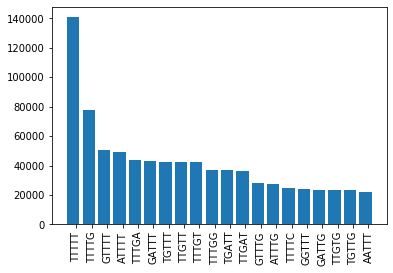

here
there
20


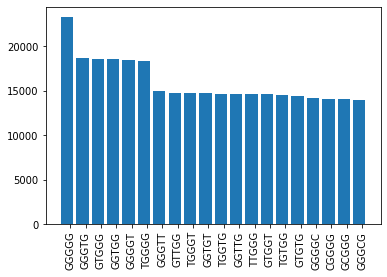

In [5]:
#make words strings.
h_DNA = np.array([[''.join(h_DNA[i,j,:]) for i in range(h_DNA.shape[0]) ]for 
                  j in range(h_DNA.shape[1])])
#make words strings.
n_DNA = np.array([[''.join(n_DNA[i,j,:]) for i in range(n_DNA.shape[0]) ]for 
                  j in range(n_DNA.shape[1])])

print(h_DNA.shape)

h_DNA_check= h_DNA.reshape(DNA_length//word_length)
n_DNA_check= n_DNA.reshape(DNA_length//word_length)
display(h_DNA_check)
h_DNA_check1=[]
n_DNA_check1=[]


##HUMAN
print("here")
counts_h=dict(Counter(h_DNA_check).most_common(20))
print("there")
labels_h, values_h = zip(*counts_h.items())

#sort
indsort_h = np.argsort(values_h)[::-1]

#re_arrange
labels_h= np.array(labels_h)[indsort_h]
values_h= np.array(values_h)[indsort_h]
indexes_h = np.arange(len(values_h))
bar_width=0.2
plt.bar(indexes_h, values_h)
plt.xticks(indexes_h+bar_width,labels_h, rotation= 90)
print(len(counts_h))

plt.show()

##NEANDERTHAL
print("here")
counts_n=dict(Counter(n_DNA_check).most_common(20))
print("there")
labels_n, values_n = zip(*counts_n.items())

#sort
indsort_n = np.argsort(values_n)[::-1]

#re_arrange
labels_n= np.array(labels_n)[indsort_n]
values_n= np.array(values_n)[indsort_n]
indexes_n = np.arange(len(values_n))
bar_width=0.2
plt.bar(indexes_n, values_n)
plt.xticks(indexes_n+bar_width,labels_n, rotation= 90)
print(len(counts_n))

plt.show()

In [6]:
# Prepare data for the NN

h_DNA_NN=[' '.join(h_DNA[i,:]) for i in range(h_DNA.shape[0])]
n_DNA_NN=[' '.join(n_DNA[i,:]) for i in range(n_DNA.shape[0])]

DNA_NN = h_DNA_NN+n_DNA_NN
Y = [1]*len(h_DNA_NN)+[0]*len(n_DNA_NN)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(DNA_NN)

encoded_docs = tokenizer.texts_to_sequences(DNA_NN)
max_length = max([len(s.split()) for s in DNA_NN])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42, shuffle = True)

print(X_train.shape)
print(len(Y_train))

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

(28800, 200)
28800
1025


In [10]:
# build LSTM

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length = max_length))
model.add(SpatialDropout1D(0.2)) # MATTEO: HO AGGIUNTO QUESTO LAYER PERCHE' METTERE DROPOUT DENTRO EMBEDDING NON è PIù SUPPORTATO
#model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))  #this sucks
model.add(LSTM(10, dropout = 0.2, recurrent_dropout = 0.2))  #totally killing it
#model.add(Conv1D(10, dropout = 0.2, recurrent_dropout = 0.2)) 
model.add(Dense(5,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 32)           32800     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 34,581
Trainable params: 34,581
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
epochs = 10
history = model.fit(X_train, Y_train, 
                    epochs = epochs, 
                    verbose = 1, 
                    validation_split = 0.2, 
                    batch_size = 32, 
                    shuffle = True, 
                    callbacks = [checkpoint])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23040 samples, validate on 5760 samples
Epoch 1/10
23040/23040 [==============================] - 189s 8ms/step - loss: 0.6142 - accuracy: 0.9744 - val_loss: 0.5122 - val_accuracy: 1.0000
Epoch 2/10


/home/ubuntu/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


23040/23040 [==============================] - 191s 8ms/step - loss: 0.4626 - accuracy: 0.9963 - val_loss: 0.4087 - val_accuracy: 1.0000
Epoch 3/10
23040/23040 [==============================] - 193s 8ms/step - loss: 0.3781 - accuracy: 0.9976 - val_loss: 0.3428 - val_accuracy: 1.0000
Epoch 4/10
23040/23040 [==============================] - 184s 8ms/step - loss: 0.3214 - accuracy: 0.9983 - val_loss: 0.2954 - val_accuracy: 1.0000
Epoch 5/10
23040/23040 [==============================] - 188s 8ms/step - loss: 0.2824 - accuracy: 0.9979 - val_loss: 0.2630 - val_accuracy: 1.0000
Epoch 6/10
23040/23040 [==============================] - 190s 8ms/step - loss: 0.2506 - accuracy: 0.9987 - val_loss: 0.2351 - val_accuracy: 1.0000
Epoch 7/10
23040/23040 [==============================] - 185s 8ms/step - loss: 0.2270 - accuracy: 0.9987 - val_loss: 0.2148 - val_accuracy: 1.0000
Epoch 8/10
23040/23040 [==============================] - 181s 8ms/step - loss: 0.2076 - accuracy: 0.9989 - val_loss: 0.196

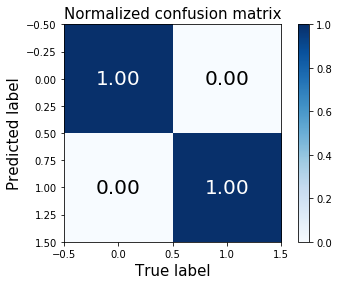

In [12]:
predicted_labels = model.predict(X_test)
cm = confusion_matrix(Y_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 15)
plt.colorbar()
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

## Really complicated dna differentiation

Imagine a chain of nucleotides, divided in genes and intragenic DNA. Genes must be functioning, so they have a pattern, intragenic DNA not, so it can be random.

...intagrenic----gene----intragenic---gene---intragenic....

GENES

We have N genes. Genes have the same order among neanderthal and humans:

Hair--Height--Eyes--Beard.. <- Neanderthal 

Hair--Height--Eyes--Beard.. <- Human

Humans and neanderthal are similar, so they have similar genes. Hence for a sigle gene i decided to have different variants, like brown hair, blond hairs, but they have to differ for small variation otherwise you would be bald.

From a logic point of view, change a small number of nucleotides from a random sequence so you have the variants, but they keep the same lenght in all the variants.

Genes have correlations between themselves, decided randomly between a random number of genes. For example Genes 1,8,15 are correlated in humans, correlations between 3 elements-> why? 3 is sampled from a "discrete gaussian", why 1,8,15 choseen random.

INTRAGENIC

We have N+1 intragenic sequence, of variable lenght interposed between genes.

How humans differ from neanderthal??

Intragenic dna different in lenght, for example in a human intragenic dna between genes 1 and 2, contains 100 nucleotides, while in the neanderthal 90. Correlations between different genes. like neanderthal correlates Nose and Beard, while human Height and Fat percentage.

How humans differ from humans and neanderthal from neanderthal?

Same intragenic lenght, but different nucleotides. Different genes variants.

In [17]:
#Manopole
#decide the percentage of geneDNA in a sentence.
pc_genes = 0.5

#How many genes?
N_genes = 50

#Choose genes to correlate

#How many?
avg_dimension_of_correlation_clusters = 3

b=0.4 #how different are different genes ? max 0.5
fraction_of_mutations_per_gene=0.1#percentage of random mutations in gene variants
variants=3 #how may variants?


N_people= 3000
sentence_length= 2000 #HOW LONG A SENTENCE in letters


word_length=5 #HOW LONG A WORD in letters

#do you want same intragenic location in neanderthals and humans?
same = True

#Sorry i did not implemented different genes..

In [18]:
#Build Genes

genes_nucleotides = (sentence_length*pc_genes) //1 
intragenic_nucleotides= sentence_length - genes_nucleotides

print(genes_nucleotides)
print(intragenic_nucleotides)

#How many intergenic sequences?
N_intragenic=N_genes+1

def split_in_different_leghts_sequence(how_many_nucleotides_for_genes, how_many_sequences):
    N_n=how_many_nucleotides_for_genes
    N_s=how_many_sequences
    seqs=np.zeros(N_s)
    for i in range(len(seqs)-1):
        while(True):
            ls=int(np.random.poisson((N_n/N_s)))
            if ls>1: 
                break
        N_n=N_n-ls
        N_s=N_s-1
        seqs[i]=int(ls)
    seqs[-1]=N_n
    return(seqs)

genes_char=split_in_different_leghts_sequence(genes_nucleotides, N_genes)
intragenic_char_humans=split_in_different_leghts_sequence(intragenic_nucleotides, N_intragenic)
if same == False : 
    intragenic_char_neanderthal=split_in_different_leghts_sequence(intragenic_nucleotides, N_intragenic)
else :
    intragenic_char_neanderthal=intragenic_char_humans

print(sum(intragenic_char_neanderthal))
print(sum(intragenic_char_humans))
print(genes_char)

#Now I have the characterization of all genic and intragenic sequences

1000.0
1000.0
1000.0
1000.0
[15. 17. 28. 20. 20. 17. 20. 20. 18. 16. 18. 23. 34. 30. 19. 22. 17. 18.
 27. 16. 17. 13. 15. 21. 17. 21. 18. 16. 16. 18. 18. 22. 19. 33. 14. 22.
 17. 21. 17. 26. 25. 22. 21. 18. 25. 14. 13. 24. 15. 27.]


In [19]:
def correlate_genes(N_genes,cluster_dim):
    clusters=[]
    genes=[i for i in range((N_genes))]
    while(len(genes) != 0):
        while (True):
            curr_cl= int(np.random.poisson((cluster_dim)))
            if curr_cl <= len(genes) and curr_cl>0: break
            #else: print(curr_cl, len(genes))
        clusters.append(np.random.choice(genes, curr_cl, False))
        for c in clusters[-1]:
            genes.remove(c)
    return((clusters))

corrs_human=correlate_genes(N_genes,avg_dimension_of_correlation_clusters)
corrs_neanderthal=correlate_genes(N_genes,avg_dimension_of_correlation_clusters)
print("Theese are the correlation cluster, dont worry about the NAN it simply means that this cluster is smaller thna the number of columns")       
print("human")
display(pd.DataFrame(corrs_human)) 
print("neandertal")
display(pd.DataFrame(corrs_neanderthal))

#Now i got the genes that are correlated.
#In future we can include different genes correlations between human and neanderthal

Theese are the correlation cluster, dont worry about the NAN it simply means that this cluster is smaller thna the number of columns
human


,0,1,2,3,4,5
0,43,30.0,10.0,NaN,NaN,NaN
1,40,45.0,3.0,NaN,NaN,NaN
2,24,44.0,31.0,NaN,NaN,NaN
3,35,49.0,NaN,NaN,NaN,NaN
4,15,18.0,14.0,NaN,NaN,NaN
5,12,26.0,19.0,NaN,NaN,NaN
6,6,28.0,NaN,NaN,NaN,NaN
7,39,13.0,17.0,1.0,0.0,47.0
8,4,42.0,34.0,7.0,11.0,NaN
9,33,8.0,38.0,22.0,16.0,36.0


neandertal


,0,1,2,3,4,5
0,6,27.0,19.0,39.0,44.0,30.0
1,35,32.0,48.0,37.0,NaN,NaN
2,16,23.0,41.0,46.0,40.0,NaN
3,49,4.0,7.0,20.0,28.0,47.0
4,34,0.0,8.0,45.0,NaN,NaN
5,12,5.0,NaN,NaN,NaN,NaN
6,25,NaN,NaN,NaN,NaN,NaN
7,1,33.0,13.0,17.0,9.0,43.0
8,29,18.0,NaN,NaN,NaN,NaN
9,15,24.0,10.0,38.0,NaN,NaN


In [20]:
#Now let's build the genes and their variants.

var=variants-1 # ;) read the code and you'll know why
genes=[]

#Here we build the single gene

for i in range(N_genes):    
    tmp_var=np.random.random(4)*2*b +(0.5-b)
    distr_f_a_gene=tmp_var/sum(tmp_var)
    #print(np.cumsum(distr_f_a_gene))
    genes_tmp=[]
    for j in range(int(genes_char[i])): 
        MC_1=np.random.random(1)
        which_nucleotide=0
        for lim in np.cumsum(distr_f_a_gene):
            if(MC_1<=lim): 
                genes_tmp.append(which_nucleotide)
                MC_1= 0
                break
            else:   which_nucleotide+=1 
    genes.append(genes_tmp)
#now add random mutations to characterize each variant.
#we'll have genes->n variants
genes_nv=genes
genes=[]
#print(genes[0][0])

i=0
for gene in genes_nv:
    tmp_var=[]
    tmp_var.append(gene)
    for j in range(var) :
        mutations_where=[]
        mutations_where=np.random.choice(range(len(gene)), 
                                    (int(fraction_of_mutations_per_gene*len(gene))) , False)
        #print(range(len(gene)))
        
        tmp_a=list(gene)
        for m_w in mutations_where:
            tmp_a[m_w]=np.random.randint(4)
            
        tmp_var.append(tmp_a)
    genes.append(tmp_var)
        
print("you got these number of variants per gene : ",len(genes[0]))

you got these number of variants per gene :  3


In [21]:
#Make a prob_distr for each correlation cluster, to choose the variants
corr_distr_human=[]
corr_distr_nean=[]
for i in range(len(corrs_human)):
    prob_xcorr=np.random.random(var+1)
    prob_xcorr=np.cumsum(prob_xcorr)/sum(prob_xcorr)
    corr_distr_human.append(prob_xcorr)
for i in range(len(corrs_neanderthal)):
    prob_xcorr=np.random.random(var+1)
    prob_xcorr=np.cumsum(prob_xcorr)/sum(prob_xcorr)
    corr_distr_nean.append(prob_xcorr)

print("Limits for the Monte Carlo, columns as many as the variants, rows as many as the correlation clusters")    
print("human")
display(corr_distr_human)
print("nean")
display(corr_distr_nean)

Limits for the Monte Carlo, columns as many as the variants, rows as many as the correlation clusters
human


[array([0.26706426, 0.81887529, 1.        ]),
 array([0.56257231, 0.89852605, 1.        ]),
 array([0.32162726, 0.64273611, 1.        ]),
 array([0.58889324, 0.83173316, 1.        ]),
 array([0.36858813, 0.74305497, 1.        ]),
 array([0.29278642, 0.71123589, 1.        ]),
 array([0.58992592, 0.7002543 , 1.        ]),
 array([0.30414602, 0.63624611, 1.        ]),
 array([0.40294156, 0.59078856, 1.        ]),
 array([0.22600089, 0.60620652, 1.        ]),
 array([0.33097797, 0.67108524, 1.        ]),
 array([0.60186228, 0.96042483, 1.        ]),
 array([0.114591  , 0.16250784, 1.        ]),
 array([0.05621771, 0.5448101 , 1.        ]),
 array([0.02010825, 0.440064  , 1.        ]),
 array([0.12585039, 0.52124891, 1.        ]),
 array([0.19024175, 0.22414998, 1.        ])]

nean


[array([0.26236464, 0.50951186, 1.        ]),
 array([0.2758502, 0.7555994, 1.       ]),
 array([0.22569602, 0.71939549, 1.        ]),
 array([0.16288765, 0.54020084, 1.        ]),
 array([0.46047609, 0.5070118 , 1.        ]),
 array([0.44797973, 0.96900396, 1.        ]),
 array([0.06992587, 0.8413092 , 1.        ]),
 array([0.42620319, 0.96016079, 1.        ]),
 array([0.18101944, 0.502305  , 1.        ]),
 array([0.06051212, 0.5491738 , 1.        ]),
 array([0.04039207, 0.736052  , 1.        ]),
 array([0.49051014, 0.72746901, 1.        ]),
 array([0.32536672, 0.92499708, 1.        ]),
 array([0.02443939, 0.57994216, 1.        ])]

In [22]:
from IPython.display import clear_output

neanderthals=[]
humans=[]

for person in range(N_people):

    clear_output(wait="True")
    print("Loading : ",person, "/", N_people )
    #Build genome 
    human_genome_info=np.zeros(N_genes)
    for i in range(len(corr_distr_human)):
        for gene in corrs_human[i]:
            which_variants=0           
            MC_2=np.random.random()
            for lim in corr_distr_human[i]:
                if(MC_2<=lim): 
                    human_genome_info[gene]=which_variants
                    MC_2= 0
                    break
                else: which_variants+=1
    print(human_genome_info)

    nean_genome_info=np.zeros(N_genes)
    for i in range(len(corr_distr_nean)):
        for gene in corrs_neanderthal[i]:
            which_variants=0           
            MC_2=np.random.random()
            for lim in corr_distr_nean[i]:
                if(MC_2<=lim): 
                    nean_genome_info[gene]=which_variants
                    MC_2= 0
                    break
                else: which_variants+=1
    print(nean_genome_info)


    #Build genes:

    human_genome=[]
    nean_genome=[]
    for i in range(len(human_genome_info)):
        human_genome.append(genes[i][int(human_genome_info[i])])
    for i in range(len(nean_genome_info)):
        nean_genome.append(genes[i][int(nean_genome_info[i])])
    human_genome_info=[]
    nean_genome_info=[]

    #build intragenic
    human_intra=[]
    nean_intra=[]
    for i in range(len(intragenic_char_humans)):
        human_intra.append(np.random.randint(4,size=int(intragenic_char_humans[i])))

    for i in range(len(intragenic_char_neanderthal)):
        nean_intra.append(np.random.randint(4,size=int(intragenic_char_humans[i])))

    #build genome

    human_DNA= list(human_intra[0])
    nean_DNA= list(nean_intra[0])
    print(human_DNA)
    for i in range(0,N_genes):
        for nuc in human_genome[i]:
            human_DNA.append(nuc)
        for nuc in human_intra[i+1]:
            human_DNA.append(nuc)
        for nuc in nean_genome[i]:
            nean_DNA.append(nuc)
        for nuc in nean_intra[i+1]:
            nean_DNA.append(nuc)
    #to letters

    human_genome=[]
    nean_genome=[]
    nean_intra=[]
    humna_intra=[]

    my_d={0:'A',1:'C',2:'G',3:'T'}
    for i in range(len(human_DNA)):
        human_DNA[i]=my_d[human_DNA[i]]
    for i in range(len(nean_DNA)):
        nean_DNA[i]=my_d[nean_DNA[i]]
    
    humans.append(human_DNA)
    neanderthals.append(nean_DNA)
humans=np.array(humans)
neanderthals=np.array(neanderthals)

print(humans.shape)
print(neanderthals.shape)

#divide in words
h_DNA= np.array(np.split(humans, sentence_length//word_length, axis=1  ))
n_DNA= np.array(np.split(neanderthals, sentence_length//word_length , axis=1 ))

print(h_DNA.shape)
print(n_DNA.shape)

Loading :  2999 / 3000
[1. 0. 0. 0. 2. 2. 2. 0. 1. 0. 2. 0. 2. 1. 1. 0. 2. 2. 2. 1. 2. 1. 1. 1.
 0. 2. 1. 2. 2. 0. 0. 2. 1. 0. 0. 0. 1. 2. 0. 2. 0. 1. 0. 1. 0. 0. 2. 1.
 0. 0.]
[2. 1. 1. 1. 2. 0. 0. 1. 2. 1. 2. 1. 0. 1. 0. 1. 1. 1. 1. 2. 1. 1. 1. 2.
 2. 0. 0. 2. 1. 2. 2. 1. 0. 0. 0. 1. 2. 0. 2. 1. 1. 1. 1. 1. 2. 2. 2. 0.
 0. 1.]
[0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 1, 0, 2, 1]
(3000, 2000)
(3000, 2000)
(400, 3000, 5)
(400, 3000, 5)


(3000, 400)


array(['AACCG', 'AAATG', 'TCTTA', ..., 'GAAAC', 'AGTGA', 'CAATT'],
      dtype='<U5')

here
there
20


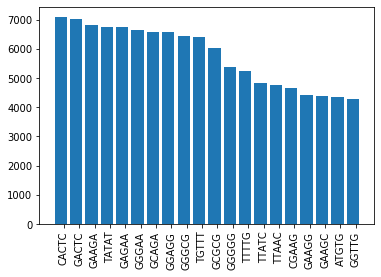

here
there
20


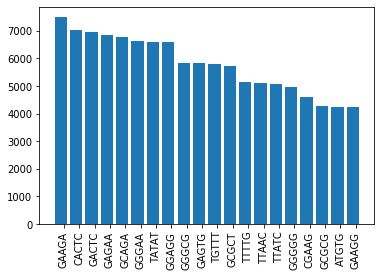

In [23]:
DNA_length= sentence_length*N_people
#make words strings.
h_DNA = np.array([[''.join(h_DNA[i,j,:]) for i in range(h_DNA.shape[0]) ]for 
                  j in range(h_DNA.shape[1])])
#make words strings.
n_DNA = np.array([[''.join(n_DNA[i,j,:]) for i in range(n_DNA.shape[0]) ]for 
                  j in range(n_DNA.shape[1])])

print(h_DNA.shape)

h_DNA_check= h_DNA.reshape(DNA_length//word_length)
n_DNA_check= n_DNA.reshape(DNA_length//word_length)
display(h_DNA_check)
h_DNA_check1=[]
n_DNA_check1=[]

##HUMAN
print("here")
counts_h=dict(Counter(h_DNA_check).most_common(20))
print("there")
labels_h, values_h = zip(*counts_h.items())

#sort
indsort_h = np.argsort(values_h)[::-1]

#re_arrange
labels_h= np.array(labels_h)[indsort_h]
values_h= np.array(values_h)[indsort_h]
indexes_h = np.arange(len(values_h))
bar_width=0.2
plt.bar(indexes_h, values_h)
plt.xticks(indexes_h+bar_width,labels_h, rotation= 90)
print(len(counts_h))

plt.show()

##NEANDERTHAL
print("here")
counts_n=dict(Counter(n_DNA_check).most_common(20))
print("there")
labels_n, values_n = zip(*counts_n.items())

#sort
indsort_n = np.argsort(values_n)[::-1]

#re_arrange
labels_n= np.array(labels_n)[indsort_n]
values_n= np.array(values_n)[indsort_n]
indexes_n = np.arange(len(values_n))
bar_width=0.2
plt.bar(indexes_n, values_n)
plt.xticks(indexes_n+bar_width,labels_n, rotation= 90)
print(len(counts_n))

plt.show()

In [24]:
h_DNA_NN=[' '.join(h_DNA[i,:]) for i in range(h_DNA.shape[0])]
n_DNA_NN=[' '.join(n_DNA[i,:]) for i in range(n_DNA.shape[0])]

DNA_NN = h_DNA_NN+n_DNA_NN
Y = [1]*len(h_DNA_NN)+[0]*len(n_DNA_NN)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(DNA_NN)

encoded_docs = tokenizer.texts_to_sequences(DNA_NN)
max_length = max([len(s.split()) for s in DNA_NN])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42, shuffle = True)

print(X_train.shape)
print(len(Y_train))

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

(4800, 400)
4800
1025


In [25]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU
from keras import regularizers

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length = max_length, dropout = 0.2))
#model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))  #this sucks
model.add(LSTM(10, dropout = 0.2, recurrent_dropout = 0.2))  #totally killing it
#model.add(Conv1D(10, dropout = 0.2, recurrent_dropout = 0.2)) 

model.add(Dense(5,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  if __name__ == '__main__':


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 400, 32)           32800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 34,581
Trainable params: 34,581
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
epochs = 10
history = model.fit(X_train, Y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3840 samples, validate on 960 samples
Epoch 1/10
3840/3840 [==============================] - 60s 16ms/step - loss: 0.7597 - accuracy: 0.5630 - val_loss: 0.7399 - val_accuracy: 0.5458
Epoch 2/10


/home/ubuntu/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3840/3840 [==============================] - 60s 16ms/step - loss: 0.7272 - accuracy: 0.6091 - val_loss: 0.7164 - val_accuracy: 0.6802
Epoch 3/10
3840/3840 [==============================] - 60s 15ms/step - loss: 0.7086 - accuracy: 0.5852 - val_loss: 0.7022 - val_accuracy: 0.6833
Epoch 4/10
3840/3840 [==============================] - 58s 15ms/step - loss: 0.6985 - accuracy: 0.6411 - val_loss: 0.6957 - val_accuracy: 0.6781
Epoch 5/10
3840/3840 [==============================] - 57s 15ms/step - loss: 0.6943 - accuracy: 0.6521 - val_loss: 0.6941 - val_accuracy: 0.6635
Epoch 6/10
3840/3840 [==============================] - 57s 15ms/step - loss: 0.6927 - accuracy: 0.7529 - val_loss: 0.6958 - val_accuracy: 0.6823
Epoch 7/10
3840/3840 [==============================] - 57s 15ms/step - loss: 0.6863 - accuracy: 0.7719 - val_loss: 0.7028 - val_accuracy: 0.6750
Epoch 8/10
3840/3840 [==============================] - 57s 15ms/step - loss: 0.6747 - accuracy: 0.7844 - val_loss: 0.7189 - val_accura

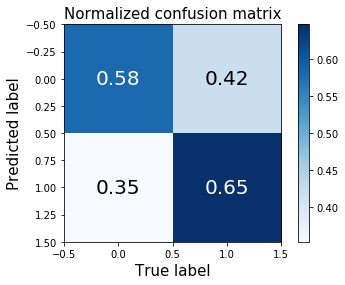

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

predicted_labels = model.predict(X_test)
cm = confusion_matrix(Y_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 15)
plt.colorbar()
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()